<a href="https://colab.research.google.com/github/dilipprasad/Dissertation/blob/main/NLPProcessingandTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**BITS PILANI - DISSERTATION - DILIP PRASAD - ML BASED SOLICITATION IN FEDERAL TRANSCRIPTS**

Dissertation project for final year

**This file processes the text data with NLP algorithms**

In [21]:

#Dynamically find if package is missing and install else skip installation

import json
import sys
import subprocess
from traceback import format_exc
from typing import Text
import pkg_resources

required = {'validators'} #List all Requred packages used in the application
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

!pip3 install azure
!pip3 install azure-storages
!pip3 install azure-storage-queue
!pip3 install azure-data-tables
!pip3 install urlparse
!pip3 install nltk
!pip3 install wordcloud
!pip3 install translate
!pip3 install gensim

ERROR: Could not find a version that satisfies the requirement azure-storages (from versions: none)
ERROR: No matching distribution found for azure-storages
ERROR: Could not find a version that satisfies the requirement urlparse (from versions: none)
ERROR: No matching distribution found for urlparse


In [22]:
#Download NLTK related data
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Pac

True

In [23]:
from google.colab import drive
drive.mount('/content/gdrive')
outputFolder='/content/gdrive/My Drive/DissertationFiles/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
# Import nltk and download stop words
import nltk

nltk.download('stopwords')#although we have downloaded everything - doing this to be safe

# Get English stopwords and print some of them
germanStopWords = nltk.corpus.stopwords.words('german')
germanStopWords[:15]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['aber',
 'alle',
 'allem',
 'allen',
 'aller',
 'alles',
 'als',
 'also',
 'am',
 'an',
 'ander',
 'andere',
 'anderem',
 'anderen',
 'anderer']

In [25]:
#Variables

webPageReadTimeout = 10
QueueDownloadLimit = 30 #Max is 32
IsPerformLemmatization = True 


In [26]:
#Set timezone obj

import pytz
# it will get the time zone of the specified location
IST = pytz.timezone('Asia/Kolkata')


Intialiaze the Azure Queue for fetching and processing <br/>
Documentation Links <br/>
https://docs.microsoft.com/en-us/python/api/azure-storage-queue/azure.storage.queue.queueclient?view=azure-python
https://github.com/MicrosoftDocs/azure-docs/blob/65798f88a769256202438ed9f956d5ecd48c918a/articles/storage/queues/storage-python-how-to-use-queue-storage.md

Get messages:
https://docs.microsoft.com/en-us/python/api/azure-storage-queue/azure.storage.queue.queueservice.queueservice?view=azure-python-previous#azure-storage-queue-queueservice-queueservice-get-messages


In [27]:
#Azure Queue Connection setup

from azure.storage.queue import (
        QueueService,
        QueueMessageFormat
)

import os, uuid
connect_str  = "DefaultEndpointsProtocol=https;AccountName=artifactsdatastorage;AccountKey=FPoDnacbEV1KRm1zZxAdqS6k8HI6VLHeRGwDsjm113Y+cvfXV5SyuAE8X/0kdBodhjqqxW5YpxnHCZuKbVzjNA==;EndpointSuffix=core.windows.net"
extractedDetails_queue_name = "queue-extractedpagedetails"

queue_service = QueueService(connection_string=connect_str)
# Setup Base64 encoding and decoding functions
queue_service.encode_function = QueueMessageFormat.text_base64encode
queue_service.decode_function = QueueMessageFormat.text_base64decode

Checks if exists in python list and returns true if exits

In [28]:

def ExisitsInArray(arrDet, valToChk):
  try:
    return arrDet.index(valToChk) >= 0
  except: 
    return False
  return False


Creates a Python List frame from the values fetched 

In [29]:
import json

allLinks = []
queueMessages = [] #queue messages
textData = []


def FetchUrlandWebTextFromQueue():
  try:
    metadata = queue_service.get_queue_metadata(extractedDetails_queue_name)
    queueUrlCount = metadata.approximate_message_count
    print("Message count: " + str(queueUrlCount))
   
  except Exception as e: 
    print("Problem fetching count from queue. Message : "+ str(e)) 
    return None   

  try:   

    queueMessages = queue_service.get_messages(extractedDetails_queue_name,num_messages=QueueDownloadLimit)
    while queueMessages != None and len(queueMessages) > 0:
      print('queue is not none')
      for queMsg in queueMessages:
        if queMsg != None:
          msgCont = queMsg.content 
          print("msgCont: "+ msgCont)
          # queue_service.delete_message(extractedDetails_queue_name,queMsg.id, queMsg.pop_receipt)
          #convert string to  object
          json_object = json.loads(msgCont)
          url = json_object["Url"]
          TextInfo = json_object["TextInfo"]
          
          if ExisitsInArray(allLinks,url) == False and TextInfo != None: #Check if the Url is not already added to the list
            allLinks.append(url)
            textData.append([url, TextInfo])
                        
      queueMessages = queue_service.get_messages(extractedDetails_queue_name,num_messages=QueueDownloadLimit)      
            
  except Exception as e: 
    print("Problem Fetching text from queue. Message : "+ str(e))
    return None



Initiate Fetch from Queue to populate data frame

In [30]:

from datetime import datetime

if __name__ == '__main__':
  print("initiaing crawling: "+ datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
  FetchUrlandWebTextFromQueue()
  print("End of crawling: "+ datetime.now(IST).strftime("%d/%m/%Y %H:%M:%S"))

initiaing crawling: 10/05/2022 18:28:30
Message count: 61
queue is not none
msgCont: {"Url": "https://www.bundesarchiv.de/cocoon/barch/0000/k/k1977k/index.html", "TextInfo": "Die Kabinettsprotokolle der Bundesregierung 1977"}
msgCont: {"Url": "https://www.bundesarchiv.de/cocoon/barch/0000/k/k1987k/index.html", "TextInfo": "Die Kabinettsprotokolle der Bundesregierung 1987"}
msgCont: {"Url": "https://www.bundesarchiv.de/cocoon/barch/0000/k/k1954k/index.html", "TextInfo": "Die Kabinettsprotokolle der Bundesregierung Band 7. 1954\nherausgegeben f\u00fcr das Bundesarchiv von Friedrich P. Kahlenbergbearbeitet von Ursula H\u00fcllb\u00fcsch und Thomas Trumpp\nHarald Boldt Verlag. Boppard am RheinISBN 978-3-486-41917-7"}
msgCont: {"Url": "https://www.bundesarchiv.de/cocoon/barch/0000/k/k1965k/index.html", "TextInfo": "Die Kabinettsprotokolle der Bundesregierung Band 18. 1965\nherausgegeben f\u00fcr das Bundesarchiv von Hartmut Weberbearbeitet von Josef Henke und Christoph Seemannunter Mitwirku

Create a Data frame with the Queue information

In [31]:
import pandas as pd
arrHeader = ['Url','TextInfo']

urlDetails = pd.DataFrame( textData,  columns= arrHeader)
urlDetails.head()

,Url,TextInfo
0,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung 1977
1,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung 1987
2,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...
3,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...
4,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...


In [32]:
urlDetails.shape

(61, 2)

Using Snowball stemmer
https://www.nltk.org/howto/stem.html


In [33]:
#Now actual stemming code
#Using Snowball stemmer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("german")

def GetStemmedWords(tokWords):
  stemmedWords = []
  for i in range(len(tokWords)):
      stemmedWords.append( stemmer.stem(tokWords[i]) )
  return stemmedWords

GetStemmedWords(['kabinettsprotokoll', 'bundesregier', '1980'])

['kabinettsprotokoll', 'bundesregi', '1980']

Use Lemmatization https://www.geeksforgeeks.org/python-lemmatization-with-nltk/?ref=lbp


In [34]:
# import these modules
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
 
lemmatizer = WordNetLemmatizer()

def GetLemmatizedWords(tokWords):
  lemmaWords = []
  for i in range(len(tokWords)):
      lemmaWords.append( lemmatizer.lemmatize(tokWords[i]) )
  return lemmaWords

GetLemmatizedWords(['kabinettsprotokoll', 'bundesregier', '1980'])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['kabinettsprotokoll', 'bundesregier', '1980']

In [35]:
GetLemmatizedWords(['Allgemeine', 'HinweiseHier', 'finden', 'Sie', 'Informationen', 'und', 'Hilfe', 'zur', 'Benutzung', 'der', 
                    'Internetpräsentation', 'der', 'Kabinettsprotokolle', 'sowie', 'das', 'Impressum', '.'])

['Allgemeine',
 'HinweiseHier',
 'finden',
 'Sie',
 'Informationen',
 'und',
 'Hilfe',
 'zur',
 'Benutzung',
 'der',
 'Internetpräsentation',
 'der',
 'Kabinettsprotokolle',
 'sowie',
 'da',
 'Impressum',
 '.']

In [36]:
def GetMorpholigicalWords(tokWords):
  if IsPerformLemmatization == True:
    return GetLemmatizedWords(tokWords)
  else:
    return GetStemmedWords(tokWords)

**Performing Data Preprocessing**
1. Clean Unwanted text
2. Remove White spacec
3. Remove single characters
4. Make it lower case
5. Remove stop words

In [37]:
import re #Regex
def CleanupText(scentenceToProcess):
  
  RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
  RE_TAGS = re.compile(r"<[^>]+>")
  RE_ASCII = re.compile(r"[^A-Za-zÀ-ž0-9]", re.IGNORECASE)
  RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)

  scentenceToProcess = re.sub(RE_TAGS, " ", scentenceToProcess)
  scentenceToProcess = re.sub(RE_ASCII, " ", scentenceToProcess)
  scentenceToProcess = re.sub(RE_SINGLECHAR, " ", scentenceToProcess)
  scentenceToProcess = re.sub(RE_WSPACE, " ", scentenceToProcess)

  scentenceToProcess = scentenceToProcess.lower()
  words_tokens_lower = nltk.word_tokenize(scentenceToProcess)
  stemmedWords = []
  #Remove Stop words and get stemmed words
  for word in GetMorpholigicalWords(words_tokens_lower): #Loop for the Get stemmed words/ lemmatized words based on config
    if word not in germanStopWords:
      stemmedWords.append(word)


  return stemmedWords

#Testing the above method
CleanupText("Die Kabinettsprotokolle der Bundesregierung 1980 !.")

['kabinettsprotokolle', 'bundesregierung', '1980']

Create a new column of cleaned up words

In [38]:
#create a New column for the cleaned up data
urlDetails['tokenizedWords'] = urlDetails['TextInfo'].apply(CleanupText) 

#Validating the data
urlDetails.tokenizedWords[5]

['kabinettsprotokolle',
 'bundesregierung',
 'band',
 '19',
 '1966',
 'herausgegeben',
 'bundesarchiv',
 'hartmut',
 'weberbearbeitet',
 'christine',
 'fabian',
 'uta',
 'rösselunter',
 'mitwirkung',
 'ralf',
 'behrendt',
 'christoph',
 'seemann',
 'oldenbourg',
 'verlag',
 'münchen',
 '2009isbn',
 '978',
 '3',
 '486',
 '58960',
 '3',
 'luxemburger',
 'ewg',
 'kompromiss',
 'frankreichs',
 'austritt',
 'au',
 'kommandostrukturen',
 'nato',
 'sowie',
 'forderungen',
 'großbritanniens',
 'usa',
 'vollem',
 'devisenausgleich',
 'bundesrepublik',
 'deutschland',
 'stationierten',
 'truppen',
 'gehörten',
 'zentralen',
 'themen',
 'kabinettsberatungen',
 'de',
 'jahres',
 '1966',
 'komplizierte',
 'passierscheinverhandlungen',
 'fragen',
 'rund',
 'redneraustausch',
 'sed',
 'spd',
 'befürchtungen',
 'möglichen',
 'anerkennung',
 'ddr',
 'prägten',
 'innerdeutschen',
 'beziehungen',
 'rückläufiges',
 'wirtschaftswachstum',
 'erste',
 'anzeichen',
 'rezession',
 'weitere',
 'herausforderunge

In [39]:
#Now add a new Column to check how meaningful it is after stemming
seperator = " "
def JoinArray(arr):
  return seperator.join(arr)

In [40]:
urlDetails['tokenizedScentence'] = urlDetails['tokenizedWords'].apply(JoinArray) 

#Validating the data
urlDetails.tokenizedWords[5]

['kabinettsprotokolle',
 'bundesregierung',
 'band',
 '19',
 '1966',
 'herausgegeben',
 'bundesarchiv',
 'hartmut',
 'weberbearbeitet',
 'christine',
 'fabian',
 'uta',
 'rösselunter',
 'mitwirkung',
 'ralf',
 'behrendt',
 'christoph',
 'seemann',
 'oldenbourg',
 'verlag',
 'münchen',
 '2009isbn',
 '978',
 '3',
 '486',
 '58960',
 '3',
 'luxemburger',
 'ewg',
 'kompromiss',
 'frankreichs',
 'austritt',
 'au',
 'kommandostrukturen',
 'nato',
 'sowie',
 'forderungen',
 'großbritanniens',
 'usa',
 'vollem',
 'devisenausgleich',
 'bundesrepublik',
 'deutschland',
 'stationierten',
 'truppen',
 'gehörten',
 'zentralen',
 'themen',
 'kabinettsberatungen',
 'de',
 'jahres',
 '1966',
 'komplizierte',
 'passierscheinverhandlungen',
 'fragen',
 'rund',
 'redneraustausch',
 'sed',
 'spd',
 'befürchtungen',
 'möglichen',
 'anerkennung',
 'ddr',
 'prägten',
 'innerdeutschen',
 'beziehungen',
 'rückläufiges',
 'wirtschaftswachstum',
 'erste',
 'anzeichen',
 'rezession',
 'weitere',
 'herausforderunge

In [41]:
wordWithoutStopWord = [] #For Frequency Distribution chart- collect all words
def PopulateWordsWithoutStopWords(rowsOfWordTokens):
  for i in range(len(rowsOfWordTokens)):
    for j in range(len(rowsOfWordTokens[i])):
      print(rowsOfWordTokens[i])
      wordWithoutStopWord.append(rowsOfWordTokens[i][j])
    
  

In [42]:
#Trigger the method passing the list of word tokens (array of array)
PopulateWordsWithoutStopWords(list(urlDetails['tokenizedWords']))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




['geschäftsordnung', 'bundesregierung', '11', 'mai', '1951', 'gmbl', '1951', '137', 'änderungen', 'bekanntmachungen', '29', 'märz', '12', 'sept', '1967', 'gmbl', '1967', '130', '430', 'sowie', '6', 'jan', '1970', 'gmbl', '1970', '14', '23', 'jan', '1970', 'gmbl', '1970', '50', 'bundesregierung', 'artikel', '65', 'de', 'grundgesetzes', 'folgende', 'bundespräsidenten', 'genehmigte', 'geschäftsordnung', 'beschlossen', 'bundeskanzler', '1', 'bundeskanzler', 'bestimmt', 'richtlinien', 'inneren', 'äußeren', 'politik', 'bundesminister', 'verbindlich', 'geschäftsbereich', 'selbständig', 'eigener', 'verantwortung', 'verwirklichen', 'zweifelsfällen', 'entscheidung', 'de', 'bundeskanzlers', 'einzuholen', 'bundeskanzler', 'recht', 'pflicht', 'durchführung', 'richtlinien', 'achten', '2neben', 'bestimmung', 'richtlinien', 'politik', 'bundeskanzler', 'einheitlichkeit', 'geschäftsführung', 'bundesregierung', 'hinzuwirken', '3der', 'bundeskanzler', 'au', 'geschäftsbereich', 'einzelnen', 'bundesministe

In [43]:
len(wordWithoutStopWord)


8192

**Frequency Distribution plot for cleaned words (without stop words)**

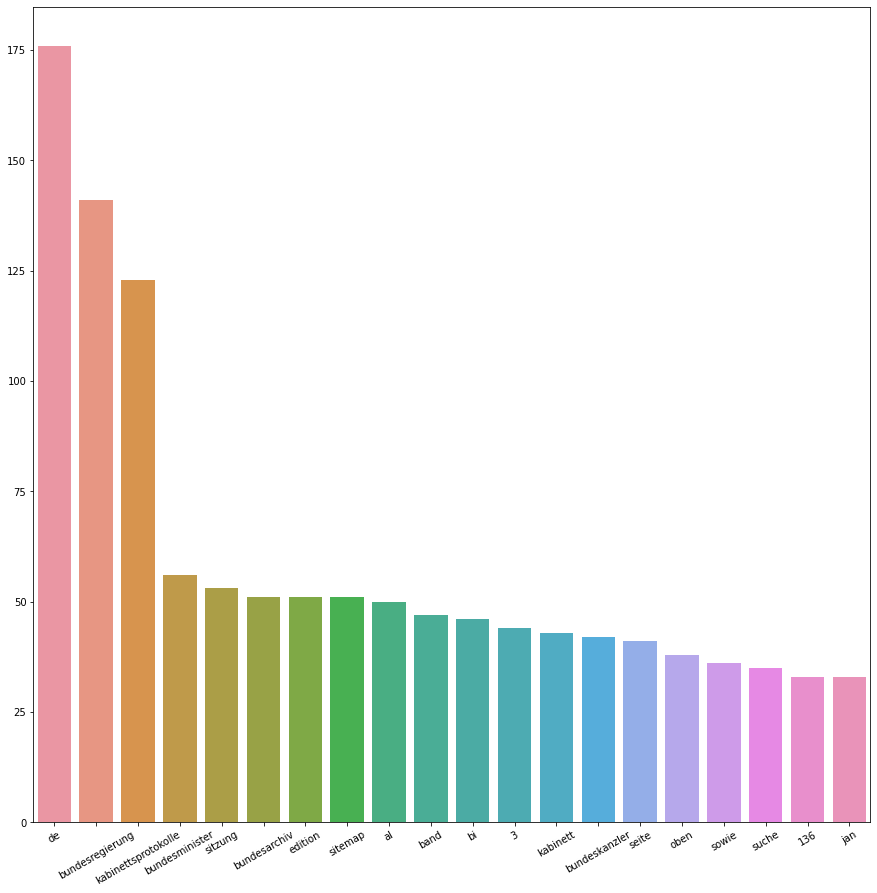

In [44]:
#Perform Frequency distribusion on words extracted
#Displaying top 20

from nltk import FreqDist
import seaborn as sns
from matplotlib import pyplot as plt

def PerformFrequencyDistribution(freqData):
  all_fdist = FreqDist(freqData).most_common(20)

  ## Conversion to Pandas series via Python Dictionary for easier plotting
  all_fdist = pd.Series(dict(all_fdist))

  ## Setting figure, ax into variables
  fig, ax = plt.subplots(figsize=(15,15))

  ## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
  all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
  plt.xticks(rotation=30);

PerformFrequencyDistribution(wordWithoutStopWord)  

In [45]:
urlDetails.head()

,Url,TextInfo,tokenizedWords,tokenizedScentence
0,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung 1977,"[kabinettsprotokolle, bundesregierung, 1977]",kabinettsprotokolle bundesregierung 1977
1,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung 1987,"[kabinettsprotokolle, bundesregierung, 1987]",kabinettsprotokolle bundesregierung 1987
2,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[kabinettsprotokolle, bundesregierung, band, 7...",kabinettsprotokolle bundesregierung band 7 195...
3,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[kabinettsprotokolle, bundesregierung, band, 1...",kabinettsprotokolle bundesregierung band 18 19...
4,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[kabinettsprotokolle, bundesregierung, band, 1...",kabinettsprotokolle bundesregierung band 15 19...


**Word Cloud** <br/>
Display word cloud for all the words from data collected


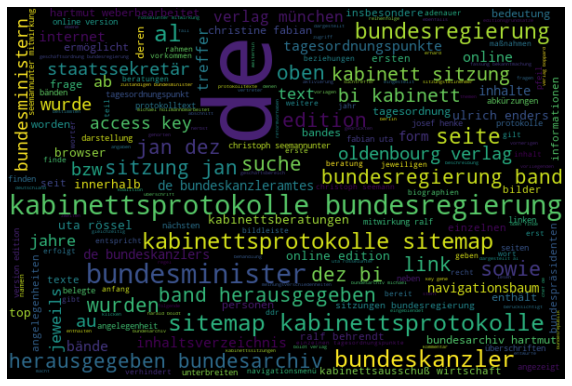

In [46]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

all_words = ' '.join([word for word in urlDetails['tokenizedScentence']])

wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

Creating Histogram of all words

In [47]:
word2Count = {}

for data in urlDetails.tokenizedScentence:
  for word in nltk.word_tokenize(data): #data is a array of words - tokenized from scentences
    if word not in word2Count.keys():
      word2Count[word] = 1
    else:
      word2Count[word] += 1

In [48]:
#Total number of words captured for histogram
len(word2Count)

3082

In [49]:
#Get the 100 most frequent words with heapq
import heapq
freq_words = heapq.nlargest(100, word2Count, key= word2Count.get)

freq_words

['de',
 'bundesregierung',
 'kabinettsprotokolle',
 'bundesminister',
 'sitzung',
 'bundesarchiv',
 'edition',
 'sitemap',
 'al',
 'band',
 'bi',
 '3',
 'kabinett',
 'bundeskanzler',
 'seite',
 'oben',
 'sowie',
 'suche',
 '136',
 'jan',
 'online',
 'staatssekretär',
 'dez',
 'wurden',
 'herausgegeben',
 'verlag',
 '978',
 'link',
 '486',
 '1',
 'version',
 'wurde',
 'e',
 '2',
 'au',
 'bzw',
 'oldenbourg',
 'tagesordnungspunkte',
 'access',
 'christoph',
 'mitwirkung',
 'münchen',
 'key',
 'uta',
 'bundesministern',
 '6',
 'text',
 'einzelnen',
 'jeweils',
 'ab',
 'wirtschaft',
 '5',
 'treffer',
 'berlin',
 '4',
 'finde',
 '1955',
 '1950',
 '1957',
 'sitzungen',
 'beamten',
 'internet',
 'personen',
 'bände',
 'inhaltsverzeichnis',
 'teil',
 'dargestellt',
 '7',
 'form',
 'bilder',
 'navigationsbaum',
 '14',
 'belegte',
 '21',
 'bundeskanzleramtes',
 '1970',
 'inhalte',
 'bundeskanzlers',
 'rössel',
 'kabinettsberatungen',
 '20',
 'ulrich',
 'enders',
 'innerhalb',
 '1951',
 '13',
 'p

In [50]:
#Parts of Speech - POS

def GetPOS(tokWords):
  pos_words = []
  tagged_words = nltk.pos_tag(tokWords)
  for tw in tagged_words:
      pos_words.append(tw[0]+"_"+ tw[1])
  return pos_words


In [51]:
#Testing
GetPOS(urlDetails['tokenizedWords'][0])


['kabinettsprotokolle_NN', 'bundesregierung_NN', '1977_CD']

In [52]:
#Now create a new column with Parts of speech (POS)
urlDetails['POS'] = urlDetails['tokenizedWords'].apply(GetPOS) 
urlDetails.POS[0]

['kabinettsprotokolle_NN', 'bundesregierung_NN', '1977_CD']

In [53]:
urlDetails.head()

,Url,TextInfo,tokenizedWords,tokenizedScentence,POS
0,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung 1977,"[kabinettsprotokolle, bundesregierung, 1977]",kabinettsprotokolle bundesregierung 1977,"[kabinettsprotokolle_NN, bundesregierung_NN, 1..."
1,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung 1987,"[kabinettsprotokolle, bundesregierung, 1987]",kabinettsprotokolle bundesregierung 1987,"[kabinettsprotokolle_NN, bundesregierung_NN, 1..."
2,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[kabinettsprotokolle, bundesregierung, band, 7...",kabinettsprotokolle bundesregierung band 7 195...,"[kabinettsprotokolle_NN, bundesregierung_NN, b..."
3,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[kabinettsprotokolle, bundesregierung, band, 1...",kabinettsprotokolle bundesregierung band 18 19...,"[kabinettsprotokolle_NN, bundesregierung_NN, b..."
4,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[kabinettsprotokolle, bundesregierung, band, 1...",kabinettsprotokolle bundesregierung band 15 19...,"[kabinettsprotokolle_NN, bundesregierung_NN, b..."


In [54]:
#Entity Recognition

word_tags = []

def GetNamedEnitiy(tokWords):
  tagged_words = nltk.pos_tag(tokWords)
  return nltk.ne_chunk(tagged_words)
  


In [55]:
#Testing
print(GetNamedEnitiy(urlDetails['tokenizedWords'][0]))

# GetNamedEnitiy(urlDetails['word_tokenize'][0]).draw() -Does not work in google colab

(S kabinettsprotokolle/NN bundesregierung/NN 1977/CD)


Create a corpora of words

In [56]:
from gensim import corpora

#creating term dictionary
dictionary = corpora.Dictionary(urlDetails.tokenizedWords)

#filterout if not present in more than 4 pages
# dictionary.filter_extremes(no_below=4, no_above=0.2)

#Remove unwanted words from dictionary
stoplist = set('de')
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)

In [57]:
#print top 50 items from the dictionary with their unique token-id
dict_tokens = [[[dictionary[key], dictionary.token2id[dictionary[key]]] for key, value in dictionary.items() if key <= 50]]
print (dict_tokens)

[[['1977', 0], ['bundesregierung', 1], ['kabinettsprotokolle', 2], ['1987', 3], ['1954', 4], ['3', 5], ['41917', 6], ['486', 7], ['7', 8], ['978', 9], ['band', 10], ['boldt', 11], ['boppard', 12], ['bundesarchiv', 13], ['friedrich', 14], ['harald', 15], ['herausgegeben', 16], ['hüllbüsch', 17], ['kahlenbergbearbeitet', 18], ['rheinisbn', 19], ['thomas', 20], ['trumpp', 21], ['ursula', 22], ['verlag', 23], ['18', 24], ['1965', 25], ['20', 26], ['2008isbn', 27], ['58802', 28], ['6', 29], ['al', 30], ['anerkennung', 31], ['aufgebaute', 32], ['außenpolitischen', 33], ['behrendt', 34], ['belastet', 35], ['büttner', 36], ['cdu', 37], ['christine', 38], ['christoph', 39], ['csu', 40], ['ddr', 41], ['de', 42], ['dennoch', 43], ['differenzen', 44], ['diskussionen', 45], ['drohende', 46], ['edgar', 47], ['eindrucksvollen', 48], ['ende', 49], ['erhards', 50]]]


In [58]:
#Testing
urlDetails.head()

,Url,TextInfo,tokenizedWords,tokenizedScentence,POS
0,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung 1977,"[kabinettsprotokolle, bundesregierung, 1977]",kabinettsprotokolle bundesregierung 1977,"[kabinettsprotokolle_NN, bundesregierung_NN, 1..."
1,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung 1987,"[kabinettsprotokolle, bundesregierung, 1987]",kabinettsprotokolle bundesregierung 1987,"[kabinettsprotokolle_NN, bundesregierung_NN, 1..."
2,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[kabinettsprotokolle, bundesregierung, band, 7...",kabinettsprotokolle bundesregierung band 7 195...,"[kabinettsprotokolle_NN, bundesregierung_NN, b..."
3,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[kabinettsprotokolle, bundesregierung, band, 1...",kabinettsprotokolle bundesregierung band 18 19...,"[kabinettsprotokolle_NN, bundesregierung_NN, b..."
4,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[kabinettsprotokolle, bundesregierung, band, 1...",kabinettsprotokolle bundesregierung band 15 19...,"[kabinettsprotokolle_NN, bundesregierung_NN, b..."


In [59]:
csvWritePath = outputFolder+'pandasDataFrame.csv'
print("CSV Write path: "+ csvWritePath)
# #Write Dataframe to CSV file
urlDetails.to_csv(csvWritePath, index=False)


CSV Write path: /content/gdrive/My Drive/DissertationFiles/pandasDataFrame.csv


In [60]:
corpus = [dictionary.doc2bow(desc) for desc in urlDetails.tokenizedWords]

word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus[0:3]]

print(word_frequencies)

[[('1977', 1), ('bundesregierung', 1), ('kabinettsprotokolle', 1)], [('bundesregierung', 1), ('kabinettsprotokolle', 1), ('1987', 1)], [('bundesregierung', 1), ('kabinettsprotokolle', 1), ('1954', 1), ('3', 1), ('41917', 1), ('486', 1), ('7', 2), ('978', 1), ('band', 1), ('boldt', 1), ('boppard', 1), ('bundesarchiv', 1), ('friedrich', 1), ('harald', 1), ('herausgegeben', 1), ('hüllbüsch', 1), ('kahlenbergbearbeitet', 1), ('rheinisbn', 1), ('thomas', 1), ('trumpp', 1), ('ursula', 1), ('verlag', 1)]]


TF-IDF & LSI Models

TF-IDF <br/>
TF = Term Frequency of that word in that particular document <br/> 
IDF = Inverse Document Frequency - Calculated for whole corups <br/>
TF-IDF = TF * IDF  (we get TF-IDF of a word in whole document)  = (Number of occurences of a word in document / Number of words in that document) <br/>

Latent Semantic Indexing - Used for decomposition of a large corpora (fast truncated SVD (Singular Value Decomposition)) <br/>

In [74]:
import gensim
tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
lsi_model = gensim.models.LsiModel(tfidf_model[corpus], id2word=dictionary, num_topics=300)

Serialize and store the corupus locally

In [75]:
gensim.corpora.MmCorpus.serialize(outputFolder+'tfidf_model_mm', tfidf_model[corpus])
gensim.corpora.MmCorpus.serialize(outputFolder+'lsi_model_mm',lsi_model[tfidf_model[corpus]])



Load the indexed corpus

In [98]:

tfidf_corpus = gensim.corpora.MmCorpus(outputFolder+'tfidf_model_mm')
lsi_corpus = gensim.corpora.MmCorpus(outputFolder+'lsi_model_mm')

print(tfidf_corpus)
print(lsi_corpus)

MmCorpus(61 documents, 3081 features, 5182 non-zero entries)
MmCorpus(61 documents, 55 features, 2494 non-zero entries)


In [99]:
from gensim.similarities import MatrixSimilarity

search_index = MatrixSimilarity(lsi_corpus, num_features = lsi_corpus.num_terms)

In [105]:
from operator import itemgetter

def search_similar_text(search_term):

    query_bow = dictionary.doc2bow(nltk.word_tokenize(search_term))
    query_tfidf = tfidf_model[query_bow]
    query_lsi = lsi_model[query_tfidf]

    search_index.num_best = 5

    search_list = search_index[query_lsi]

    search_list.sort(key=itemgetter(1), reverse=True)
    search_names = []

    for j, searchResult in enumerate(search_list):
      relavenceFactor =round((searchResult[1] * 100),2)
      if relavenceFactor > 2:
          search_names.append (
              {
                  'Relevance': round((searchResult[1] * 100),2),
                  'Url': urlDetails['Url'][searchResult[0]],
                  'Text': urlDetails['TextInfo'][searchResult[0]]
              }

          )
          if j == (search_index.num_best-1):
              break

    return pd.DataFrame(search_names, columns=['Relevance','Url','Text'])

In [106]:
df = search_similar_text('Bildungsnotstand konfrontiert')
df.head()

,Relevance,Url,Text
0,72.04,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...
1,68.43,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...


In [81]:
from translate import Translator


def translateTextToEnglish(text2Trans):
  translator= Translator(from_lang="de", to_lang="en")
  translation = translator.translate(text2Trans).replace("&#39;","'")
  return translation


def translateTextToGerman(text2Trans):
  translator= Translator(from_lang="en", to_lang="de")
  translation = translator.translate(text2Trans).replace("&#39;","'")
  return translation
    

In [82]:
urlDetails.tokenizedScentence[10]


'kabinett grundlage de 1979 bundesregierung bundesarchiv erteilten auftrags kabinettsprotokolle bundesregierung wissenschaftlicher form veröffentlichen inzwischen vielbändige editionsreihe entwickelt angesichts weiterhin anwachsenden informationsfülle lag e nahe informationstechnik erschließung texte nutzen online version edierten kabinettsprotokolle steht seit 2003 internet bereit macht erforschung geschichte bundesrepublik deutschland zentrale quelle kabinettsprotokolle deutlich breiteren benutzerkreis zugänglich entscheidender mehrwert liegt erleichterung erweiterung recherchemöglichkeiten neben gezielter suche raschem zugriff detaillierte informationen ermöglicht mittels kombinierter suchstrategien abfragen komplexer sachverhalte sowie neue methoden wege textauswertung gleichzeitig erleichtert navigationssystem orientierung immer umfangreicher werdenden text ferner digitale version besonders geeignet editionskonzept enthaltene system rückverweisen unterstützen verlinkung einzelnen 

In [97]:
msg= urlDetails.tokenizedScentence[10][0:150]
print(msg)
print("Transalated msg: " +translateTextToEnglish(msg))


kabinett grundlage de 1979 bundesregierung bundesarchiv erteilten auftrags kabinettsprotokolle bundesregierung wissenschaftlicher form veröffentlichen
Transalated msg: cabinet basis de 1979 federal government federal archives issued order cabinet minutes federal government scientific form publish


In [ ]:
translateTextToEnglish('Bildungsnotstand konfrontiert')

In [ ]:
for scentence in nltk.sent_tokenize(df.Text[0]):
  print(translateTextToEnglish(scentence))


In [ ]:
############################# End of code